In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm, multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [2]:
customer_data = pd.read_csv('customer_gmm.csv')
display(customer_data)
customer_data = (np.array(customer_data))[:, 1:]
# print(customer_data)
# print(customer_data.shape)
scaler = StandardScaler()
scaler.fit(customer_data)
customer_data = scaler.transform(customer_data)
# print(customer_data)
# print(customer_data.shape)

,Index,Gender,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,0,67,2,124670,1,2
1,1,1,1,22,1,150773,1,2
2,2,0,0,49,1,89210,0,0
3,3,0,0,45,1,171565,1,1
4,4,0,0,53,1,149031,1,1
...,...,...,...,...,...,...,...,...
1995,1995,1,0,47,1,123525,0,0
1996,1996,1,1,27,1,117744,1,0
1997,1997,0,0,31,0,86400,0,0
1998,1998,1,1,24,1,97968,0,0


[[     0      0     67 ... 124670      1      2]
 [     1      1     22 ... 150773      1      2]
 [     0      0     49 ...  89210      0      0]
 ...
 [     0      0     31 ...  86400      0      0]
 [     1      1     24 ...  97968      0      0]
 [     0      0     25 ...  68416      0      0]]
(2000, 7)
[[-0.91739884 -0.99302433  2.65361447 ...  0.09752361  0.29682303
   1.552326  ]
 [ 1.09003844  1.00702467 -1.18713209 ...  0.78265438  0.29682303
   1.552326  ]
 [-0.91739884 -0.99302433  1.11731585 ... -0.83320224 -1.26952539
  -0.90972951]
 ...
 [-0.91739884 -0.99302433 -0.41898277 ... -0.90695688 -1.26952539
  -0.90972951]
 [ 1.09003844  1.00702467 -1.01643224 ... -0.60332923 -1.26952539
  -0.90972951]
 [-0.91739884 -0.99302433 -0.93108232 ... -1.3789866  -1.26952539
  -0.90972951]]
(2000, 7)


# Implementation of Guassian Mixture Models in Python

In [40]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import silhouette_score

class GMM:
    def __init__(self, n_components, iterations=100, threshold=0.004, min_covar=5e-9):
        self.n_components = n_components
        self.means_ = None
        self.covariances_ = None
        self.prior_ = None
        self.wij = None
        self.iterations = iterations
        self.threshold = threshold
        self.converged = False
        self.log_likelihood_trace = []
        self.min_covar = min_covar

    def initialize_parameters(self, data):
        n_samples, n_features = data.shape
        self.wij = np.zeros((n_samples, self.n_components))
        np.random.seed(4)
        chosen = np.random.choice(n_samples, self.n_components, replace=False)
        self.means_ = data[chosen]
        self.prior_ = np.full(self.n_components, 1 / self.n_components)
        self.covariances_ = np.tile(np.identity(n_features), (self.n_components, 1, 1))
        return self.means_, self.covariances_, self.prior_

    def fit(self, data):
        means_, covariances_, prior_ = self.initialize_parameters(data)
        log_likelihood = 0
        for _ in range(self.iterations):
            new_log_likelihood = self.expectation_step(data)
            self.maximization_step(data)
            if abs(new_log_likelihood - log_likelihood) <= self.threshold:
                self.converged = True
                break
            log_likelihood = new_log_likelihood
            self.log_likelihood_trace.append(log_likelihood)
        return means_, covariances_, prior_

    def get_parameters(self):
        return self.means_, self.covariances_, self.prior_

    def expectation_step(self, X):
        for component in range(self.n_components):
            self.wij[:, component] = self.prior_[component] * multivariate_normal(self.means_[component], self.covariances_[component]).pdf(X)
        epsilon = 1e-16
        log_likelihood = np.sum(np.log(np.sum(self.wij, axis=1) + epsilon))
        self.wij = self.wij / (self.wij.sum(axis=1, keepdims=1) + epsilon)
        return log_likelihood

    def maximization_step(self, X):
        responsibility_weight_sum = self.wij.sum(axis=0)
        self.prior_ = responsibility_weight_sum / X.shape[0]
        self.means_ = np.dot(self.wij.T, X) / responsibility_weight_sum.reshape(-1, 1)
        for component in range(self.n_components):
            self.covariances_[component] = np.dot(self.wij[:, component] * (X - self.means_[component]).T, (X - self.means_[component])) / responsibility_weight_sum[component]
            self.covariances_[component] += self.min_covar * np.identity(X.shape[1])

    def predict(self, X):
        log_likelihood = self.calculate_log_likelihood(X)
        return np.argmax(log_likelihood, axis=1)
    
    def calculate_log_likelihood(self, X):
        n_samples = X.shape[0]
        n_components = self.n_components
        log_likelihood = np.zeros((n_samples, n_components))

        for k in range(n_components):
            prior = self.prior_[k]
            likelihood = multivariate_normal.pdf(X, self.means_[k], self.covariances_[k], allow_singular=True)
            log_likelihood[:, k] = np.log(prior * likelihood)

        return log_likelihood

    def aic(self, X):
        log_likelihood = self.calculate_log_likelihood(X)
        n_samples, n_features = X.shape
        n_params = self.n_components * (n_features + 1) + self.n_components * n_features * (n_features + 1) // 2
        aic = -2 * np.sum(log_likelihood) + 2 * n_params
        return aic

    def bic(self, X):
        log_likelihood = self.calculate_log_likelihood(X)
        n_samples, n_features = X.shape
        n_params = self.n_components * (n_features + 1) + self.n_components * n_features * (n_features + 1) // 2
        bic = -2 * np.sum(log_likelihood) + n_params * np.log(n_samples)
        return bic

    def silhouette_score(self, X):
        log_likelihood = self.calculate_log_likelihood(X)
        cluster_labels = np.argmax(log_likelihood, axis=1)
        return silhouette_score(X, cluster_labels)
        # print("Iteration")
        # print(self.means_)
        # print(self.covariances_)
        # print(self.prior_)


[-19387.022367336922, -12509.400525121659, 7545.831615817672, 44511.47562821061, 54330.73581161381, 60391.70841594297, 63976.898542959534, 64936.46802063991, 66759.76862846731, 67989.59910670188, 68465.4913209427, 68924.3873358196, 69624.99869477851, 70075.91996264571, 70100.80333860498, 70149.31216434418, 70163.56111014092, 70176.25596209947, 70188.04664652432, 70201.74857918435, 70216.55630017974, 70222.1782981485, 70226.8526578591, 70231.72391282709, 70236.81603473751, 70248.30386171432, 70251.01221130128, 70252.17951489896, 70253.23142286025, 70254.31845509104, 70255.3577540765, 70256.29601387012, 70257.29156636643, 70259.06956283195, 70267.80740327042, 70271.49034554546, 70271.9399632613, 70272.38126088028, 70272.8191874203, 70273.27398725628, 70273.80876773331, 70274.62413038997, 70276.17646573806, 70278.20327595429, 70279.88728773136, 70281.26872958435, 70282.37072466564, 70283.21962373474, 70283.85437250079, 70284.31761817119, 70284.65110495007, 70284.89210496945, 70285.0710639

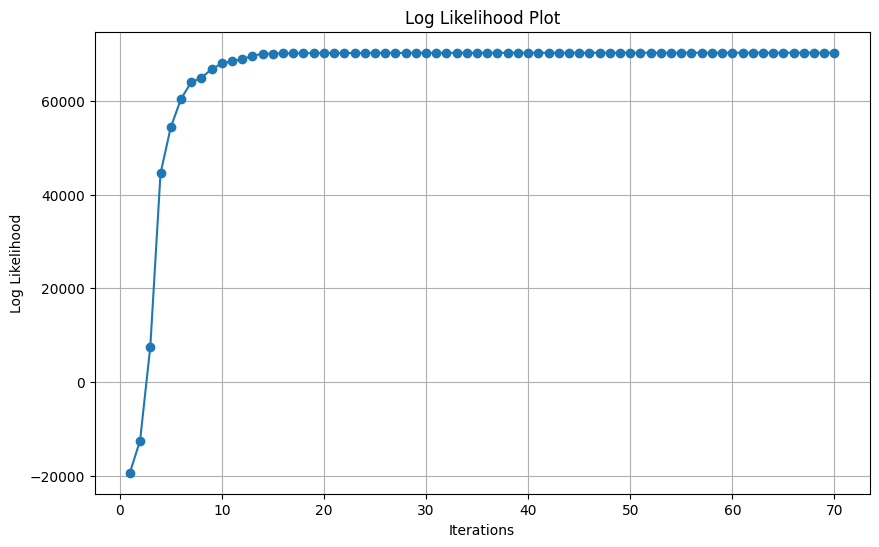

False
Custom GMM Means:
[[ 1.09003844 -0.99302433 -0.30802787 -0.06337243  0.01093409  0.29682303
   0.32129825]
 [ 1.09003844  1.00702467 -0.5043327  -0.06337243  1.80952374  1.86317144
  -0.90972951]
 [ 1.09003844  1.00702467 -0.88354597 -0.06337243 -0.96244224 -1.26952539
  -0.90972951]
 [-0.91739884 -0.99302433 -0.07758308 -0.06337243  0.62713969 -1.26952539
  -0.90972951]
 [-0.91739884 -0.99302433 -1.35783193 -1.73106782 -0.11476377  1.86317144
   1.552326  ]
 [ 1.09003844  1.00702467 -0.00590639 -0.06337243  0.11118075 -1.26952539
  -0.90972951]
 [-0.91739884 -0.99302433  0.46260562 -0.06337243 -0.85359091 -1.26952539
  -0.90972951]
 [ 1.09003844 -0.99302433 -0.17738375 -0.06337243 -0.22251735  0.29682303
  -0.90972951]
 [ 1.09003844  1.00702467 -0.58968262 -0.06337243  2.44754077  0.29682303
   1.552326  ]
 [ 1.09003844  1.00702467 -0.94821478 -0.06337243 -0.16446134  0.29682303
   0.32129825]
 [ 1.09003844  1.00702467 -0.84573239 -0.06337243  2.68326691  1.86317144
   0.3212982

/home/rohit172/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


In [38]:
gmm = GMM(n_components = 100, iterations = 70, threshold = 1e-6)
means_,covariances_,prior_ = gmm.fit(customer_data)

print(gmm.log_likelihood_trace)
plt.figure(figsize=(10, 6))
plt.plot(range(1,len(gmm.log_likelihood_trace)+1), gmm.log_likelihood_trace, marker='o', linestyle='-')
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood Plot')
plt.grid(True)
plt.show()


sklearn_gmm = GaussianMixture(n_components=gmm.n_components, covariance_type='full', tol=gmm.threshold, max_iter=gmm.iterations)
sklearn_gmm.means_init = means_
sklearn_gmm.covariances_init = covariances_
sklearn_gmm.weights_init = prior_
sklearn_gmm.fit(customer_data)

print(gmm.converged)
# Compare the results
print("Custom GMM Means:")
print(gmm.means_)
print("Scikit-learn GMM Means:")
print(sklearn_gmm.means_)

print("\nCustom GMM Covariances:")
print(gmm.covariances_)
print("Scikit-learn GMM Covariances:")
print(sklearn_gmm.covariances_)

print("\nCustom GMM Priors:")
print(gmm.prior_)
print("Scikit-learn GMM Priors:")
print(sklearn_gmm.weights_)

Iteration
[[0.17025267 4.01162216]
 [3.3191681  0.38155965]
 [0.50705434 2.28888058]]
[[[ 0.43876915 -0.4219003 ]
  [-0.4219003   3.44613577]]

 [[ 2.99463223  0.10906548]
  [ 0.10906548  0.760211  ]]

 [[ 0.54476627 -0.34964151]
  [-0.34964151  4.37585632]]]
[0.19000218 0.36077201 0.44922408]
Iteration
[[0.17025267 4.01162216]
 [3.3191681  0.38155965]
 [0.50705434 2.28888058]]
[[[ 0.43876915 -0.4219003 ]
  [-0.4219003   3.44613577]]

 [[ 2.99463223  0.10906548]
  [ 0.10906548  0.760211  ]]

 [[ 0.54476627 -0.34964151]
  [-0.34964151  4.37585632]]]
[0.19000218 0.36077201 0.44922408]
Iteration
[[0.14935684 4.22833248]
 [3.13547678 0.50210553]
 [0.60199479 2.13250881]]
[[[ 0.39150457 -0.50002889]
  [-0.50002889  2.80304376]]

 [[ 3.680224   -0.09437051]
  [-0.09437051  0.70771816]]

 [[ 0.55131313 -0.51708818]
  [-0.51708818  4.70060125]]]
[0.19184716 0.37199154 0.4361613 ]
Iteration
[[0.09281043 4.49357513]
 [3.0048065  0.54053277]
 [0.65101238 2.00987837]]
[[[ 0.34505766 -0.37956765]
 

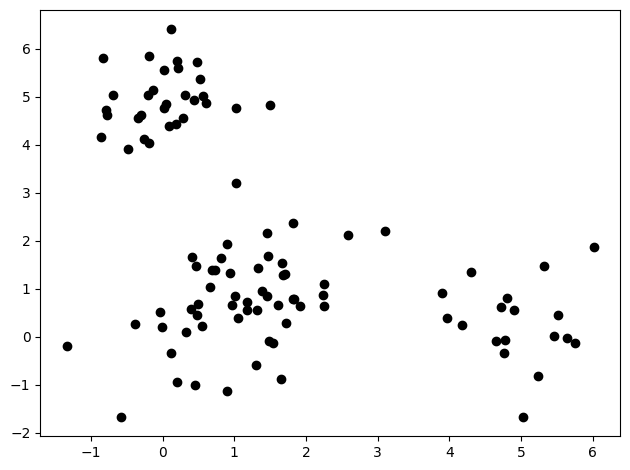

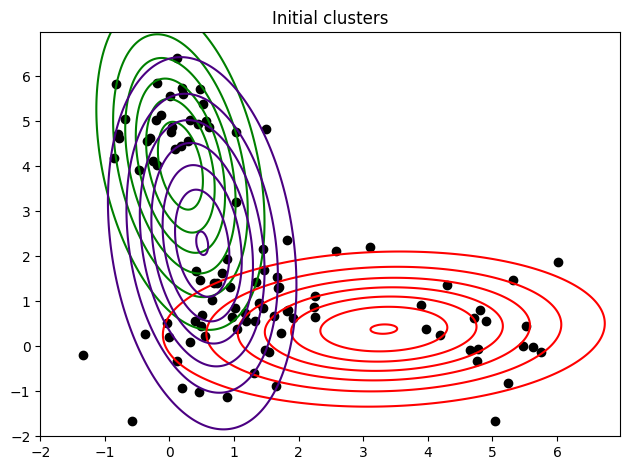

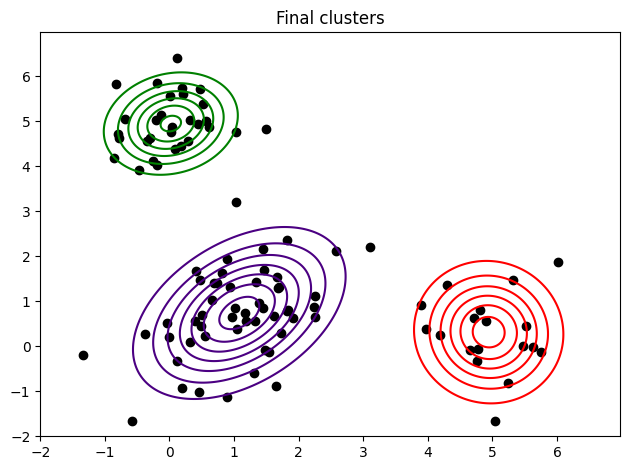

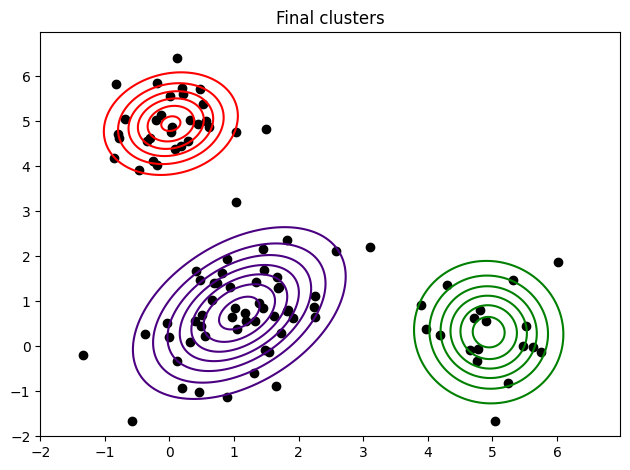

In [80]:
def generate_data(n_data, means, covariances, weights):
    """creates a list of data points"""
    n_clusters, n_features = means.shape
    
    data = np.zeros((n_data, n_features))
    for i in range(n_data):
        # pick a cluster id and create data from this cluster
        k = np.random.choice(n_clusters, size = 1, p = weights)[0]
        x = np.random.multivariate_normal(means[k], covariances[k])
        data[i] = x
   
    return data
# Model parameters, including the mean
# covariance matrix and the weights for each cluster
init_means = np.array([
    [5, 0],
    [1, 1],
    [0, 5]
])

init_covariances = np.array([
    [[.5, 0.], [0, .5]],
    [[.92, .38], [.38, .91]],
    [[.5, 0.], [0, .5]]
])

init_weights = [1 / 4, 1 / 2, 1 / 4]

# generate data
np.random.seed(4)
X = generate_data(100, init_means, init_covariances, init_weights)

plt.plot(X[:, 0], X[:, 1], 'ko')
plt.tight_layout()
def plot_contours(data, means, covs, title):
    """visualize the gaussian components over the data"""
    plt.figure()
    plt.plot(data[:, 0], data[:, 1], 'ko')

    delta = 0.025
    k = means.shape[0]
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    x_grid, y_grid = np.meshgrid(x, y)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T

    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
        plt.contour(x_grid, y_grid, z_grid, colors = col[i])

    plt.title(title)
    plt.tight_layout()

gmm = GMM(n_components = 3, iterations= 1, threshold = 1e-4)
gmm.fit(X)

plot_contours(X, gmm.means_, gmm.covariances_, 'Initial clusters')

gmm = GMM(n_components = 3, iterations = 50, threshold = 1e-4)
gmm.fit(X)

print('converged iteration:', len(gmm.log_likelihood_trace))
plot_contours(X, gmm.means_, gmm.covariances_, 'Final clusters')
# use library to confirm results
gmm = GaussianMixture(n_components = 3, covariance_type = 'full', 
                      max_iter = 600, random_state = 3)
gmm.fit(X)

print('converged or not: ', gmm.converged_)
plot_contours(X, gmm.means_, gmm.covariances_, 'Final clusters')

# GMM on Wine Dataset

/home/rohit172/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


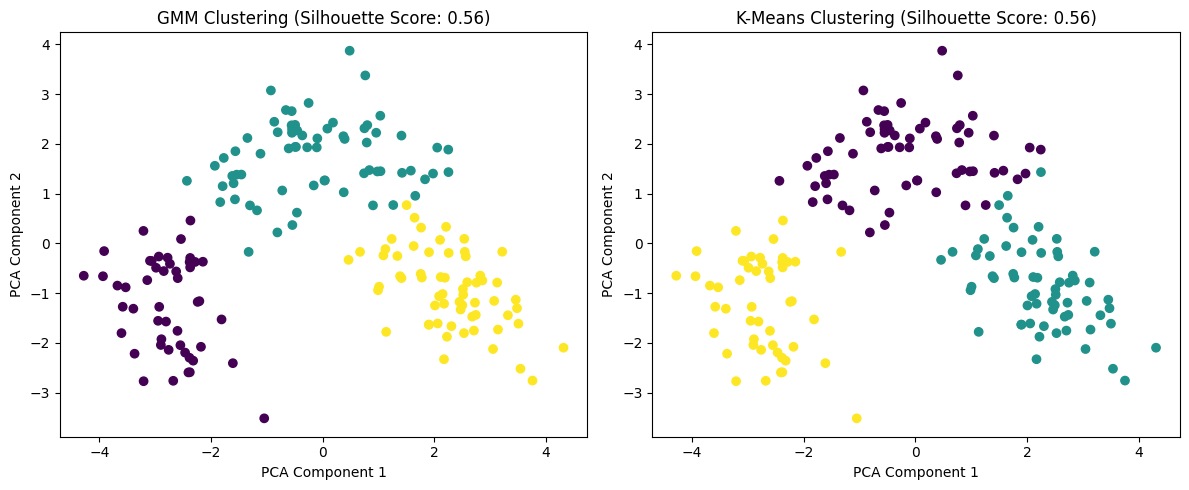

Optimal Number of Clusters (BIC): 3
Optimal Number of Clusters (AIC): 4
Silhouette Score (GMM): 0.56
Silhouette Score (K-Means): 0.56


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# Load the wine dataset
wine_data = load_wine()
X = wine_data.data
y = wine_data.target

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Find the optimal number of clusters for GMM using BIC and AIC
n_components_range = range(1, 11)
bic_scores = []
aic_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(X_pca)
    bic_scores.append(gmm.bic(X_pca))
    aic_scores.append(gmm.aic(X_pca))

optimal_n_components_bic = n_components_range[np.argmin(bic_scores)]
optimal_n_components_aic = n_components_range[np.argmin(aic_scores)]

# Fit GMM with optimal number of clusters
gmm = GaussianMixture(n_components=optimal_n_components_bic, random_state=0)
gmm_labels = gmm.fit_predict(X_pca)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=optimal_n_components_bic, random_state=0)
kmeans_labels = kmeans.fit_predict(X_pca)

# Compute silhouette scores for GMM and K-Means
silhouette_gmm = silhouette_score(X_pca, gmm_labels)
silhouette_kmeans = silhouette_score(X_pca, kmeans_labels)

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis')
plt.title(f'GMM Clustering (Silhouette Score: {silhouette_gmm:.2f})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis')
plt.title(f'K-Means Clustering (Silhouette Score: {silhouette_kmeans:.2f})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

# Print results
print(f'Optimal Number of Clusters (BIC): {optimal_n_components_bic}')
print(f'Optimal Number of Clusters (AIC): {optimal_n_components_aic}')
print(f'Silhouette Score (GMM): {silhouette_gmm:.2f}')
print(f'Silhouette Score (K-Means): {silhouette_kmeans:.2f}')


In [54]:
from sklearn.cluster import KMeans
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
# Load the wine dataset
wine_data = load_wine()
X = wine_data.data
y = wine_data.target
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)
n_components_range = range(1, 11)
bic_scores = []
aic_scores = []

for n_components in n_components_range:
    gmm = GMM(n_components=n_components, iterations = 100, threshold = 1e-10)
    gmm.fit(X_pca)
    bic_scores.append(gmm.bic(X_pca))
    aic_scores.append(gmm.aic(X_pca))


optimal_n_components_bic = n_components_range[np.argmin(bic_scores)]
optimal_n_components_aic = n_components_range[np.argmin(aic_scores)]
print(optimal_n_components_bic)
print(optimal_n_components_aic)

# Fit GMM with optimal number of clusters
gmm = GMM(n_components=optimal_n_components_bic,iterations = 70, threshold = 1e-6)
gmm.fit(X_pca)
gmm_labels = gmm.predict(X_pca)

print(gmm_labels)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=optimal_n_components_bic, random_state=0)
kmeans_labels = kmeans.fit_predict(X_pca)

# Compute silhouette scores for GMM and K-Means
silhouette_gmm = silhouette_score(X_pca, gmm_labels)
silhouette_kmeans = silhouette_score(X_pca, kmeans_labels)

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis')
plt.title(f'GMM Clustering (Silhouette Score: {silhouette_gmm:.2f})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis')
plt.title(f'K-Means Clustering (Silhouette Score: {silhouette_kmeans:.2f})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

# Print results
print(f'Optimal Number of Clusters (BIC): {optimal_n_components_bic}')
print(f'Optimal Number of Clusters (AIC): {optimal_n_components_aic}')
print(f'Silhouette Score (GMM): {silhouette_gmm:.2f}')
print(f'Silhouette Score (K-Means): {silhouette_kmeans:.2f}')


/tmp/ipykernel_8907/361588799.py:72: RuntimeWarning: divide by zero encountered in log
  log_likelihood[:, k] = np.log(prior * likelihood)


1
1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/home/rohit172/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)